In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def hough_circle_transform(edges, r_min, r_max, threshold=100):
    """
    Performs the Hough Circle Transform on an edge-detected binary image.
    
    Args:
        edges (numpy.ndarray): Binary image with detected edges (e.g., from Canny).
        r_min (int): Minimum circle radius.
        r_max (int): Maximum circle radius.
        threshold (int): Minimum vote count in the accumulator for a circle to be considered valid.
    
    Returns:
        list: A list of detected circles in the format (center_x, center_y, radius).
    """
    # Image dimensions
    height, width = edges.shape
    
    # Create a 3D accumulator array (b, a, r)
    accumulator = np.zeros((height, width, r_max+1), dtype=np.uint64)
    
    # Find edge pixels
    edge_points = np.argwhere(edges > 0)  # (y, x) points where edges exist

    # Convert angles to radians
    thetas = np.deg2rad(np.arange(0, 360))  # Angles from 0° to 359°
    
    # Iterate through edge pixels
    for y, x in edge_points:
        # Vote for centers for each radius in the given range
        for r in range(r_min, r_max+1):
            if r == 0:
                continue
            
            # Iterate through all angles to determine potential centers
            for theta in thetas:
                a = int(x - r * np.cos(theta))
                b = int(y - r * np.sin(theta))
                
                # Ensure the center (a, b) is within image bounds
                if 0 <= a < width and 0 <= b < height:
                    accumulator[b, a, r] += 1
    
    # Extract circles from accumulator exceeding threshold
    circles = []
    
    for b in range(height):
        for a in range(width):
            for r in range(r_min, r_max+1):
                if accumulator[b, a, r] >= threshold:
                    circles.append((a, b, r))
    
    return circles

# Example usage
if __name__ == "__main__":
    # Load a grayscale image or an edge-detected image
    image_path = '../datasets/image_hough_small.png'
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply edge detection (Canny)
    edges = cv2.Canny(gray, 50, 150)
    
    # Apply custom Hough Circle Transform
    found_circles = hough_circle_transform(edges, r_min=30, r_max=40, threshold=150)
    
    # Draw detected circles
    output = image.copy()
    for (cx, cy, r) in found_circles:
        # Draw the center point
        cv2.circle(output, (cx, cy), 2, (0, 255, 0), -1)
        # Draw the circle perimeter
        cv2.circle(output, (cx, cy), r, (255, 0, 0), 2)


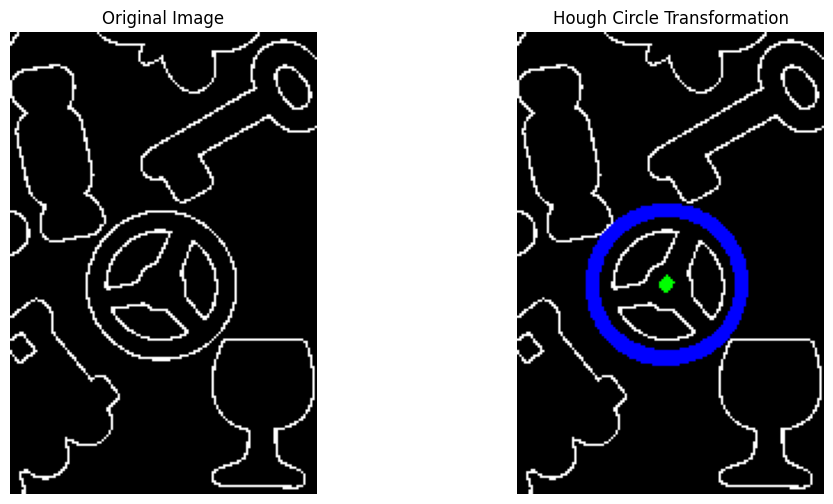

In [9]:
# Display original and output images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axes[1].set_title("Hough Circle Transformation")
axes[1].axis("off")

plt.show()
